Initialization

In [1]:
%load_ext autoreload
%autoreload 2
import unittest
from propensity_with_density import *
from true_overlap_scipy import *
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import math

Seed: 0


Parameters

In [2]:
epsilon = 0.05
N_samples = 500
dim = 2
mean2 = 1
sd1 = 1
sd2 = sd1
# nr. of randomizations of simulated data
trials = 15

# around which mean the outliers are located
outlier_mean = 5

# nr. of changes
outlier_array = [0.0, 0.025, 0.05, 0.075, 0.1]
runs = len(outlier_array)

Trials

In [3]:
def sample_normal(mean1, mean2, sd1, sd2, n, m):
    x1 = np.random.normal(mean1, sd1, (n, m))
    x2 = np.random.normal(mean2, sd2, (n, m))

    return x1, x2

def sample_normal_2_means(mean1, mean2, sd1, sd2, n, m):
    x1 = np.random.normal(mean1, sd1, (n, m))

    bool_array = np.random.choice([0, 1], size=(n,1))
    region1 = np.random.normal(-mean2, sd2, (n, m))
    region2 = np.random.normal(mean2, sd2, (n, m))
    bool_matrix = np.repeat(bool_array, m, axis=1)
    x2 = region1 * bool_matrix + region2 * (1 - bool_matrix)
    return x1, x2

# n: nr. of samples
# m: nr. of dimenions
# outliers will be taking up a % of total samples
# outlier_chance: % of samples consisting of outliers (rest % is normal samples)
# outliermean: mean where outliers are (e.g. =5, outliers will be on (5,5) if in 2D)
# returns x1, x2 and non_outlier_matrix (a vector indicating which samples are not outliers with 1 and outliers with 0)
def sample_normal_outliers(mean1, mean2, sd1, sd2, n, m, outlier_chance, outliermean):
    true_samples1, true_samples2 = sample_normal(mean1, mean2, sd1, sd2, n, m)
    outliers1, outliers2 = sample_normal(outliermean, outliermean, sd1, sd2, n, m)
    bool_array = np.random.choice([0, 1], p=[outlier_chance, 1-outlier_chance], size=(n,1))
    bool_matrix = np.repeat(bool_array, m, axis=1)
    x1 = true_samples1 * bool_matrix + outliers1 * (1 - bool_matrix)
    x2 = true_samples2 * bool_matrix + outliers2 * (1 - bool_matrix)
    # binary matrix which indicates which samples are non-outliers (with 1 being non-outlier)
    non_outlier_matrix = np.concatenate([bool_matrix, bool_matrix]).reshape(-1, m)
    return x1, x2, non_outlier_matrix

def outlier_iou(prediction, y, non_outlier_matrix):
    tp = fp = fn = 0.0
    for p, t, n in zip(prediction, y, non_outlier_matrix):
        # if not an outlier
        if n == 1:
            if p == 1:
                if t == 1:
                    tp += 1
                else:
                    fp += 1
            else:
                if t == 1:
                    fn += 1
    if (tp + fp + fn) == 0:
        return 0
    return tp / (tp + fp + fn)

classifier_names = ["lr", "dtc", "rfc"]
classifier_results = np.empty((3, runs))

for k in range(3):

    results = np.empty(runs)
    classifier = classifier_names[k]
    iou_array = np.empty(trials)

    for i in range(runs):
        print("Round: " + str(i))

        outlier_chance = outlier_array[i]
        iou_array = np.empty(trials)

        for j in range(trials):
            # Set new seed
            seed = j
            np.random.seed(seed)

            # Generate simulated data with new seed
            x1, x2, non_outlier_matrix = sample_normal_outliers(0, mean2, sd1, sd2, N_samples, dim, outlier_chance, 5)

            X = np.concatenate([x1, x2]).reshape(-1, dim)
            y = np.concatenate([np.ones(len(x1)), -np.ones(len(x2))])

            mean1_gaussian = np.zeros(dim)
            mean2_gaussian = np.ones(dim) * mean2
            cov1 = np.diag(np.ones(dim) * sd1)
            cov2 = np.diag(np.ones(dim) * sd2)
            true_overlap_labels = check_true_overlap(mean1_gaussian, mean2_gaussian, cov1, cov2, x1, x2, epsilon, dim).astype(int)

            # Setup Propensity score model
            propensity = PropensityDensity(classifier, epsilon)
            propensity.tune_hyperparameters(classifier, X, y)

            predictions = propensity.predict(X)
            iou = outlier_iou(predictions, true_overlap_labels, non_outlier_matrix[:, 0])
            iou_array[j] = (iou)

        results[i] = np.average(iou_array)
    classifier_results[k] = results

lr = classifier_results[0]
dtc = classifier_results[1]
rfc = classifier_results[2]

Round: 0
Round: 1
Round: 2
Round: 3
Round: 4
Round: 0
Round: 1
Round: 2
Round: 3
Round: 4
Round: 0
Round: 1
Round: 2
Round: 3
Round: 4


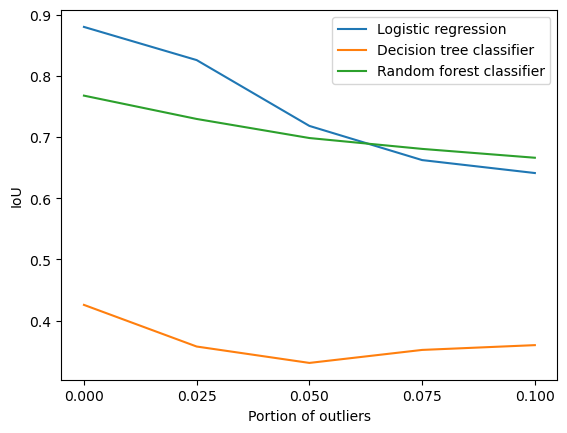

In [4]:
plt.figure(1)
plt.xticks(outlier_array)
plt.plot(outlier_array, lr, label="Logistic regression")
plt.plot(outlier_array, dtc, label="Decision tree classifier")
plt.plot(outlier_array, rfc, label="Random forest classifier")
plt.xlabel("Portion of outliers")
plt.ylabel("IoU")
plt.legend()
plt.show()

In [5]:
print("IoU:")
print(lr)
print(dtc)
print(rfc)

IoU with outliers:
[0.87996829 0.82575454 0.71815215 0.66231486 0.64114396]
[0.42564183 0.3575662  0.33077842 0.35202444 0.35984386]
[0.76765872 0.72953244 0.69836043 0.68059645 0.66613974]
